In [1]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


In [2]:
from graph.structure.graph import Graph
from graph.prior.gaussian_prior import GaussianPrior
from graph.propagator.unitary_propagator import UnitaryPropagator
from graph.measurement.gaussian_measurement import GaussianMeasurement
from core.linalg_utils import random_unitary_matrix
import numpy as np

In [3]:
# === パラメータ設定 ===
n = 64
shape = (n,)
var = 1e-4
rng = np.random.default_rng(123)

U1 = random_unitary_matrix(n, rng=rng)
U2 = random_unitary_matrix(n, rng=rng)

In [4]:
# === グラフ定義 ===
class SplitGraph(Graph):
    def __init__(self):
        super().__init__()
        self.X = GaussianPrior(mean=0.0, var=1.0, shape=shape)

        self.Y1 = UnitaryPropagator(U1) @ self.X
        self.Z1 = GaussianMeasurement(self.Y1, var=var)

        self.Y2 = UnitaryPropagator(U2) @ self.X
        self.Z2 = GaussianMeasurement(self.Y2, var=var)

        self.compile()

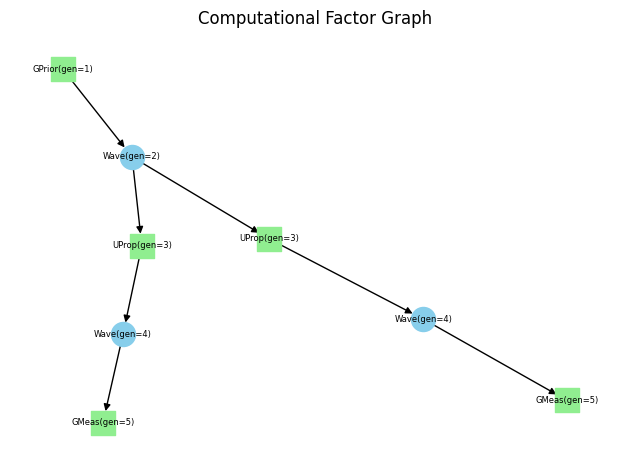

In [5]:
g = SplitGraph()
g.visualize(layout="kamada_kawai", font_size=6, scale=2.0)

In [6]:
g.set_init_rng(np.random.default_rng(1))
g.generate_sample(rng=np.random.default_rng(99))

true_x = g.X.get_sample()
g.Z1.update_observed_from_sample()
g.Z2.update_observed_from_sample()

In [7]:
np.linalg.norm(U1@true_x - g.Z1.get_sample())/64

0.002066547600578886

In [8]:
np.linalg.norm(U1@true_x - g.Z1.get_sample())**2/64

0.00027331961506933444

In [24]:
g.X.children

[UProp(gen=3), UProp(gen=3)]

In [28]:
g._nodes_sorted

[GPrior(gen=1),
 Wave(gen=2),
 UProp(gen=3),
 UProp(gen=3),
 Wave(gen=4),
 Wave(gen=4),
 GMeas(gen=5),
 GMeas(gen=5)]

In [29]:
g._nodes_sorted_reverse

[GMeas(gen=5),
 GMeas(gen=5),
 Wave(gen=4),
 Wave(gen=4),
 UProp(gen=3),
 UProp(gen=3),
 Wave(gen=2),
 GPrior(gen=1)]

In [9]:
def monitor(graph, t):
    if t % 10 == 0:
        est = graph.X.compute_belief().data
        err = np.mean(np.abs(est - true_x)**2)
        print(f"[t={t}] MSE = {err:.3e}")

g.run(n_iter=50, callback=monitor)

[t=0] MSE = 1.296e-04
[t=10] MSE = 1.294e-04
[t=20] MSE = 1.294e-04
[t=30] MSE = 1.294e-04
[t=40] MSE = 1.294e-04
